## Imports

In [61]:
import math

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics


## Load data

In [2]:
data_xlsx = pd.ExcelFile('data.xlsx')
co2_df = pd.read_excel(data_xlsx, 0)
temp_df = pd.read_excel(data_xlsx, 1)
temp_df = temp_df[1:]  # we have one extra year of data for the temperature at the start
temp_df.reset_index(drop=True, inplace=True)

In [3]:
co2_df.columns = ['year', 'y']
temp_df.columns = ['year', 'y']


## Graphing & Pre-Analysis

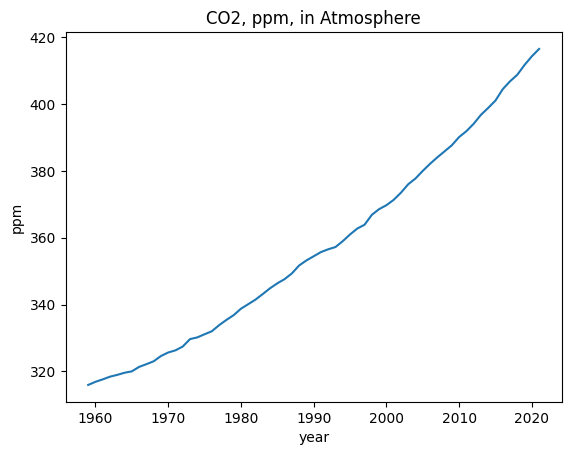

In [4]:
co2_gr = co2_df.plot(x='year', y='y', ylabel='ppm', title='CO2, ppm, in Atmosphere', legend=None)


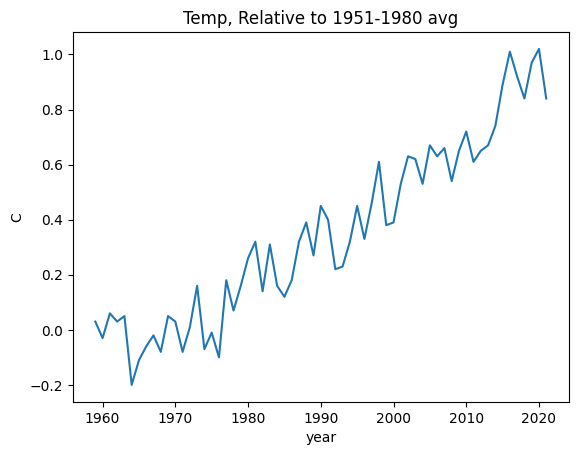

In [5]:
temp_gr = temp_df.plot(x='year', y='y', ylabel='C', title='Temp, Relative to 1951-1980 avg', legend=None)


In [6]:
ct_df = pd.concat([co2_df['y'], temp_df['y']], axis=1, keys=['co2', 'temp'])


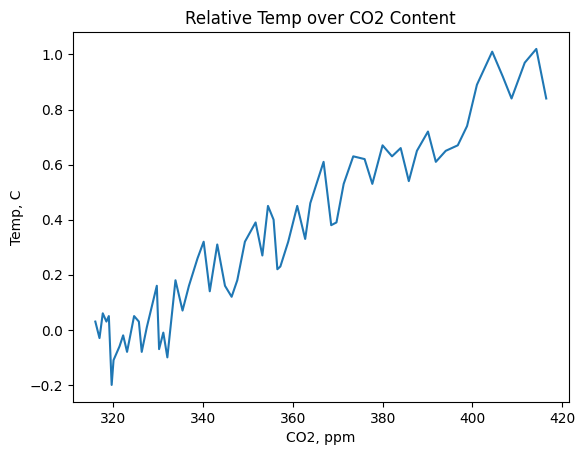

In [7]:
ct_gr = ct_df.plot(x='co2', y='temp', xlabel='CO2, ppm', ylabel='Temp, C', title='Relative Temp over CO2 Content',
                   legend=None)


## Simple Bi variate Analysis

In [8]:
def bivariate_stats(x: pd.Series, y: pd.Series):
    _pmcc = x.corr(y)
    _covr = x.cov(y)

    print(
            f'PMCC: {_pmcc} \n'
            f'r^2:  {_pmcc ** 2} \n'
            f'Cov:  {_covr}'
    )


def univariate_graphs(x: pd.Series):
    pd.plotting.autocorrelation_plot(x)
    plt.show()


def linear_reg_func(m: LinearRegression):
    _coef = m.coef_[0][0]
    _itcp = m.intercept_[0]
    print(f'Linear Regressed: y = {_coef}x {"+" if abs(_itcp) == _itcp else "-"} {abs(_itcp)}')


### CO2

PMCC: 0.9911930941405609 
r^2:  0.9824637498719389 
Cov:  542.3161290322582


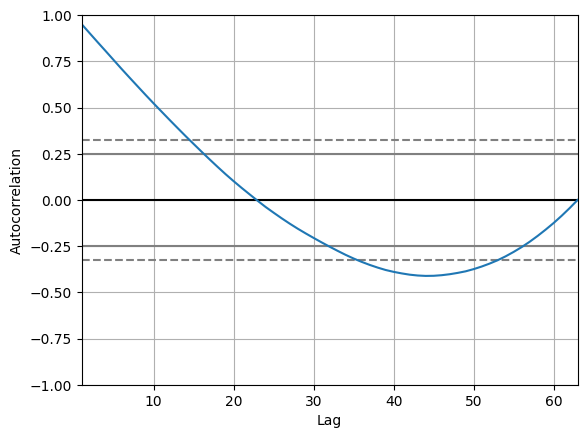

In [9]:
bivariate_stats(co2_df['year'], co2_df['y'])
univariate_graphs(co2_df['y'])

### Temperature

PMCC: 0.9477123036837343 
r^2:  0.8981586105535305 
Cov:  5.650967741935484


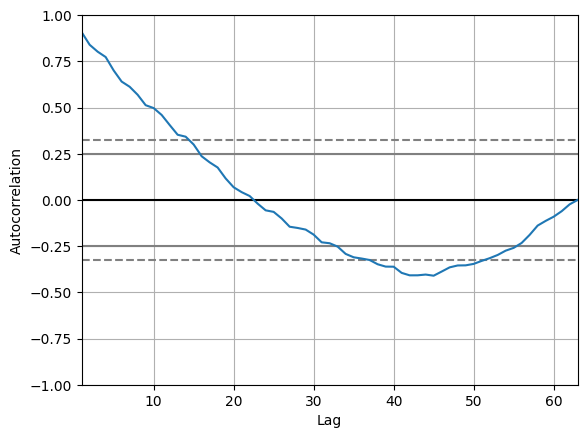

In [10]:
bivariate_stats(temp_df['year'], temp_df['y'])
univariate_graphs(temp_df['y'])

### Temperature over CO2 Content

In [11]:
ct_m_lr = LinearRegression()
ct_m_lr.fit(ct_df[['co2']], ct_df[['temp']])

ct_pred_l = ct_m_lr.predict(ct_df[['co2']])


In [12]:
bivariate_stats(ct_df['co2'], ct_df['temp'])


PMCC: 0.961318248780683 
r^2:  0.924132775438759 
Cov:  9.334014516129027


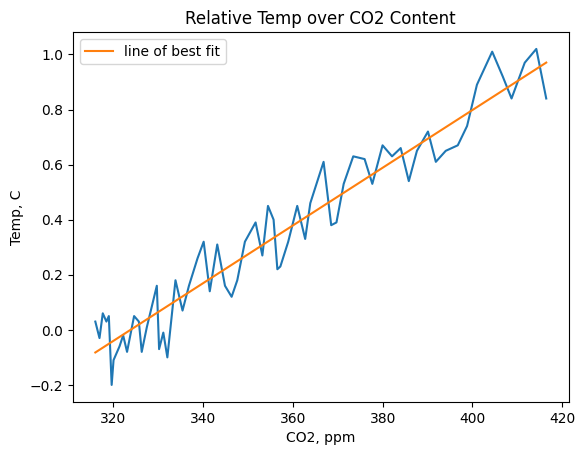

Linear Regressed: y = 0.010476572976201729x - 3.392572509671991


In [13]:
plt.plot(ct_df[['co2']], ct_df[['temp']])
plt.plot(ct_df[['co2']], ct_pred_l, label='line of best fit')
plt.title('Relative Temp over CO2 Content')
plt.ylabel('Temp, C')
plt.xlabel('CO2, ppm')
plt.legend()
plt.show()

linear_reg_func(ct_m_lr)

## CO2 Forecasting

In [14]:
PRED_YEARS = pd.DataFrame(range(1959, 2051))
PRED_YEARS.columns = ['year']

In [15]:
PRED_YEARS_PROPHET = PRED_YEARS.copy()
PRED_YEARS_PROPHET.columns = ['ds']
PRED_YEARS_PROPHET['ds'] = pd.to_datetime(PRED_YEARS_PROPHET['ds'], format='%Y')


In [49]:
def error_stats(x: pd.Series, y: pd.Series):
    _mse = metrics.mean_squared_error(x, y)
    _mae = metrics.mean_absolute_error(x, y)
    _mape = metrics.mean_absolute_percentage_error(x, y)
    _r2 = metrics.r2_score(x, y)

    print(
            f'MSE:  {_mse} \n'
            f'RMSE: {math.sqrt(_mse)} \n'
            f'R^2:  {_r2} \n'
            f'MAE:  {_mae} \n'
            f'MAPE: {_mape}%'
    )

### arima

<AxesSubplot: title={'center': 'CO2 Arima Forecast 2022-2050'}, xlabel='date', ylabel='ppm'>

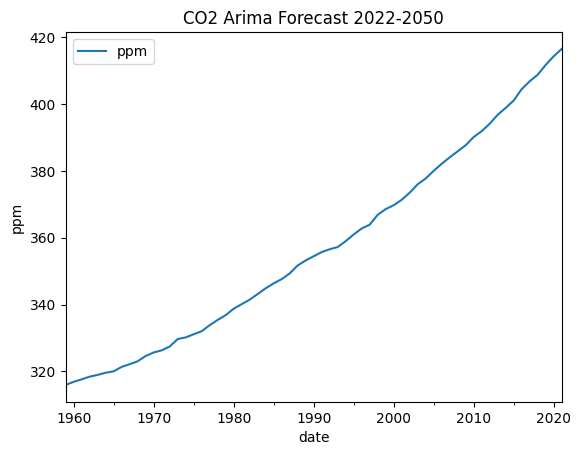

In [17]:
import statsmodels.api as sm
import statsmodels.tsa.statespace.sarimax as sarima
from statsmodels.tsa.stattools import adfuller

co2_arima = co2_df.copy()
co2_arima.columns = ['date', 'ppm']
co2_arima['date'] = pd.to_datetime(co2_arima.date, format='%Y')
co2_arima.plot(x='date', y='ppm', xlabel='date', ylabel='ppm', title='CO2 Arima Forecast 2022-2050')

In [18]:
# p-value NOT <= 0.05 hence it is non-stationary
# Stationarity - The statistical properties of a time series, process generating it do not change overtime
stationary = adfuller(co2_arima['ppm'])
stationary

(5.588259302435865,
 1.0,
 2,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 69.40020639043743)

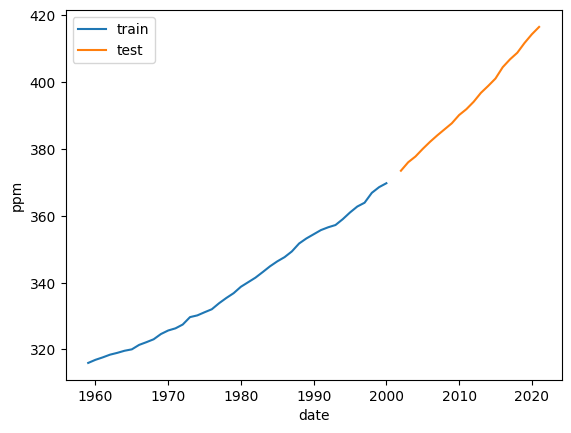

In [19]:
# (this part is for looking at model accuracies later on, ignore for now)
# checking whether first 42 data records can accurately generate last 20 data records
train = co2_arima[:42]
test = co2_arima[-20:]

plt.plot(train['date'], train['ppm'], label='train')
plt.plot(test['date'], test['ppm'], label='test')
plt.xlabel('date')
plt.ylabel('ppm')
plt.legend()

In [20]:
# grid search, exploring different param combinations


### linear

In [116]:
m_lr = LinearRegression()

m_lr.fit(co2_df[['year']], co2_df[['y']])
co2_pred_lr = m_lr.predict(PRED_YEARS)
co2_pred_lr = pd.DataFrame(co2_pred_lr)
co2_pred_lr.columns = ['y']

In [48]:
bivariate_stats(co2_df['y'], co2_pred_lr['y'][:63])
error_stats(co2_df['y'], co2_pred_lr['y'][:63])

PMCC: 0.9911930941405603 
r^2:  0.9824637498719377 
Cov:  875.317808953966
MSE:  15.375778036232472 
RMSE: 3.921195995641186 
R^2:  0.9824637498719381MAE:  3.276643990929686 
MAPE: 0.009183067163843218%


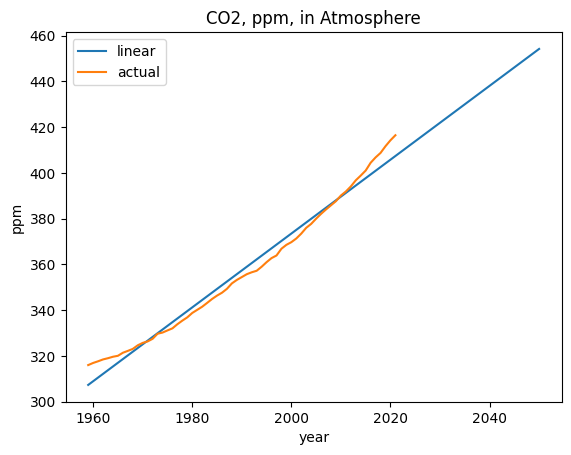

In [23]:
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()

### exponential

In [119]:
from scipy.optimize import curve_fit


In [120]:
def exp_func(x, a, b, c, d):
    return a ** (x * b + c) + d


In [121]:
pmt_co2_exp, cov = curve_fit(exp_func, co2_df['year'], co2_df['y'])
print(pmt_co2_exp)
print(cov)


[ 1.00571737e+00  2.84266152e+00 -4.85438646e+03  2.56024004e+02]
[[ 1.04860015e+02 -5.19885599e+04  8.87805151e+07 -4.92522722e+00]
 [-5.19885599e+04  2.57754147e+07 -4.40165028e+10  2.44203827e+03]
 [ 8.87805151e+07 -4.40165028e+10  7.51666866e+13 -4.17030800e+06]
 [-4.92518315e+00  2.44201642e+03 -4.17027068e+06  5.91488324e+00]]


In [122]:
co2_pred_exp = exp_func(PRED_YEARS, *pmt_co2_exp)
co2_pred_exp.columns = ['y']

In [123]:
bivariate_stats(co2_df['y'], co2_pred_exp['y'])
error_stats(co2_df['y'], co2_pred_exp['y'][:63])

print(f'Exponential Regressed: y = {pmt_co2_exp[0]:.6f}^({pmt_co2_exp[1]:.4f}x - {abs(pmt_co2_exp[2]):.1f}) + {pmt_co2_exp[3]:.3f}')

PMCC: 0.9997258887013534 
r^2:  0.9994518525397108 
Cov:  890.4531689383609
MSE:  0.4806155032785782 
RMSE: 0.6932643819486027 
R^2:  0.9994518525396857 
MAE:  0.5698107159902743 
MAPE: 0.0016425830680621178%
Exponential Regressed: y = 1.005717^(2.8427x - 4854.4) + 256.024


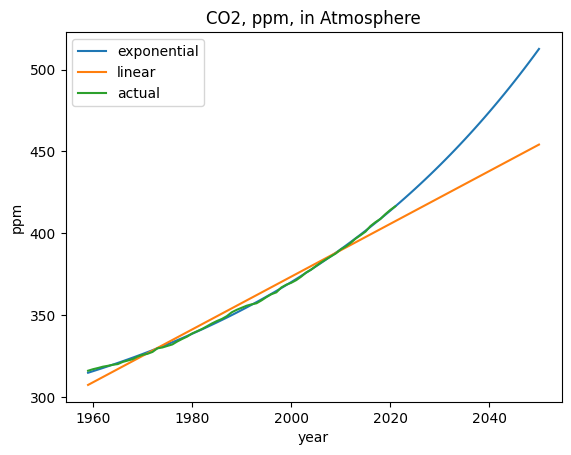

In [124]:
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


### logistic

In [125]:
def logi_func(x, a, x0, k, d):
    return a / (1 + np.exp(-k * (x - x0))) + d

In [126]:
pmt_co2_logi, cov = curve_fit(logi_func, co2_df['year'], co2_df['y'], p0=[300, 2050, 0.1, 300])
print(pmt_co2_logi)

[2.52358599e+03 2.17552141e+03 1.75874908e-02 2.60018064e+02]


In [127]:
co2_pred_logi = logi_func(PRED_YEARS, *pmt_co2_logi)
co2_pred_logi.columns = ['y']

In [128]:
bivariate_stats(co2_df['y'], co2_pred_logi['y'])
error_stats(co2_df['y'], co2_pred_logi['y'][:63])
print(
        f'Logistic Regressed: '
        f'{pmt_co2_logi[0]:.5} / '
        f'(1 + '
        f'e^(-{pmt_co2_logi[2]:.5} * (x - {pmt_co2_logi[1]:.5}))'
        f') + {pmt_co2_logi[3]}'
)

PMCC: 0.9997263684056944 
r^2:  0.9994528116856382 
Cov:  890.4540325765068
MSE:  0.4797745244565414 
RMSE: 0.6926575809565224 
R^2:  0.9994528116856191 
MAE:  0.5728621307739045 
MAPE: 0.001648042426214239%
Logistic Regressed: 2523.6 / (1 + e^(-0.017587 * (x - 2175.5))) + 260.0180641636529


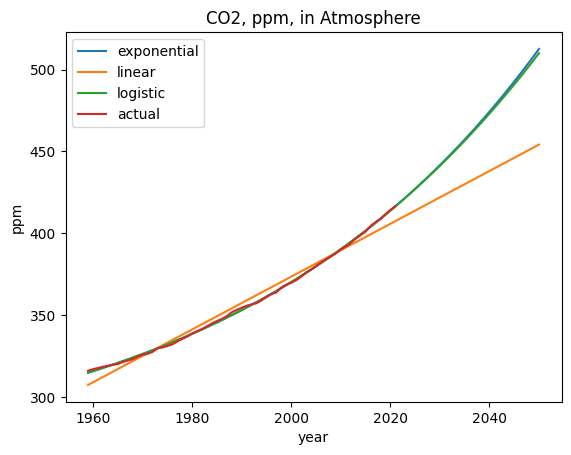

In [129]:
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(PRED_YEARS, co2_pred_logi, label='logistic')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()

In [130]:
PRED_YEARS_MORE = pd.DataFrame(range(1959, 2401))
co2_pred_logi2 = logi_func(PRED_YEARS_MORE, *pmt_co2_logi)
co2_pred_logi2.columns = ['y']

C:\Users\yiqia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


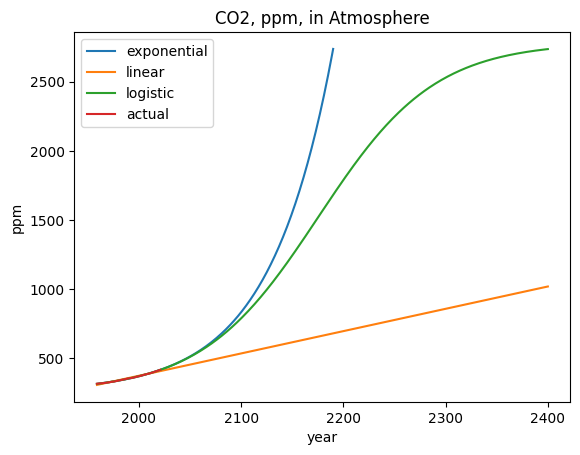

In [135]:
plt.plot(PRED_YEARS_MORE[:-210], exp_func(PRED_YEARS_MORE, *pmt_co2_exp)[:-210], label='exponential')
plt.plot(PRED_YEARS_MORE, m_lr.predict(PRED_YEARS_MORE), label='linear')
plt.plot(PRED_YEARS_MORE, co2_pred_logi2, label='logistic')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()

### prophet

In [30]:
from prophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [31]:
co2_df2 = co2_df.copy()
co2_df2.columns = ['ds', 'y']
co2_df2['ds'] = pd.to_datetime(co2_df2.ds, format='%Y')

In [32]:
P = Prophet(yearly_seasonality=False)
P.fit(co2_df2)


23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:30 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
co2_forecast_df = P.predict(PRED_YEARS_PROPHET.copy())
co2_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,316.154264,315.716843,316.571193,316.154264,316.154264,0.0,0.0,0.0,0.0,0.0,0.0,316.154264
1,1960-01-01,316.852419,316.439642,317.212591,316.852419,316.852419,0.0,0.0,0.0,0.0,0.0,0.0,316.852419
2,1961-01-01,317.552487,317.174689,317.967541,317.552487,317.552487,0.0,0.0,0.0,0.0,0.0,0.0,317.552487
3,1962-01-01,318.244058,317.831353,318.670085,318.244058,318.244058,0.0,0.0,0.0,0.0,0.0,0.0,318.244058
4,1963-01-01,318.935629,318.539459,319.341333,318.935629,318.935629,0.0,0.0,0.0,0.0,0.0,0.0,318.935629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2046-01-01,475.668703,463.416255,487.721143,463.344286,487.753966,0.0,0.0,0.0,0.0,0.0,0.0,475.668703
88,2047-01-01,478.049240,465.059488,490.684311,465.164394,490.965450,0.0,0.0,0.0,0.0,0.0,0.0,478.049240
89,2048-01-01,480.429777,466.936849,493.852288,466.874525,493.797903,0.0,0.0,0.0,0.0,0.0,0.0,480.429777
90,2049-01-01,482.816835,468.399364,496.982471,468.344729,497.090992,0.0,0.0,0.0,0.0,0.0,0.0,482.816835


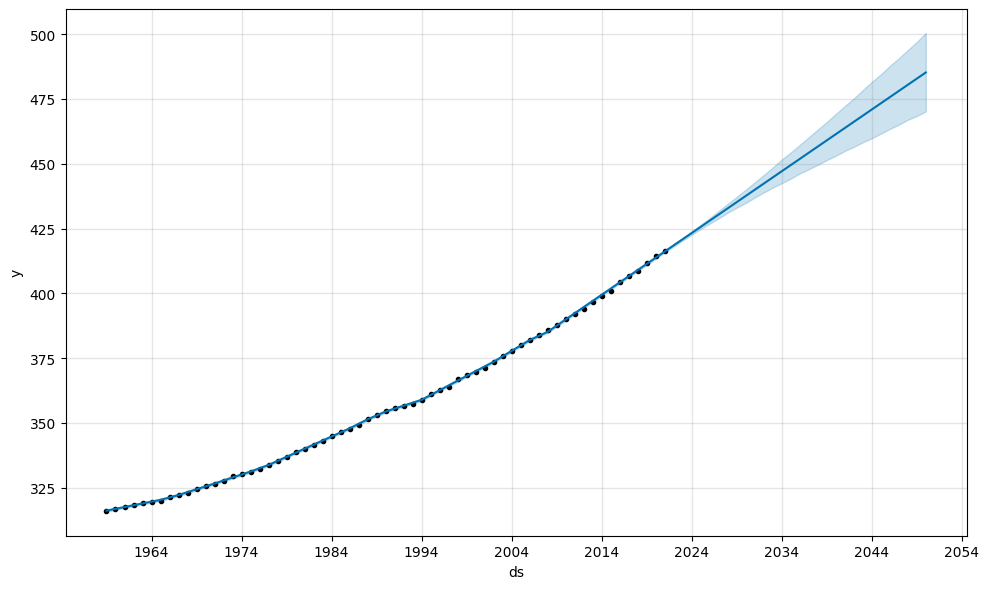

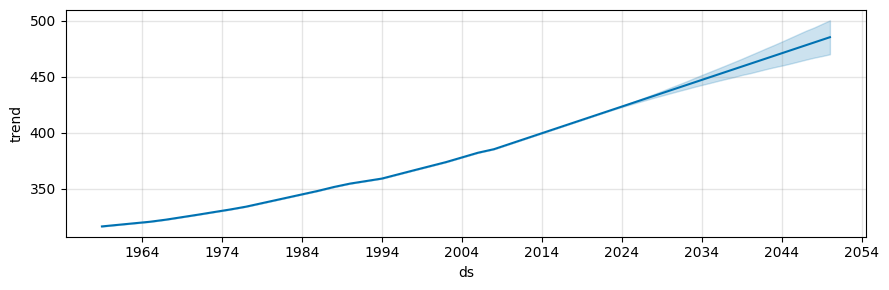

In [34]:
fig = P.plot(co2_forecast_df)
fig2 = P.plot_components(co2_forecast_df)


In [35]:
co2_pred_prophet = co2_forecast_df.copy()
co2_pred_prophet = co2_pred_prophet[['yhat']]
co2_pred_prophet.columns = ['y']

In [53]:
bivariate_stats(co2_df['y'], co2_pred_prophet['y'])
error_stats(co2_df['y'], co2_pred_prophet['y'][:63])

PMCC: 0.9999412069035434 
r^2:  0.999882417263715 
Cov:  890.8161713665066
MSE:  0.10309700037217488 
RMSE: 0.32108721614566793 
R^2:  0.9998824166958108 
MAE:  0.255074231747799 
MAPE: 0.0007003927564841805%


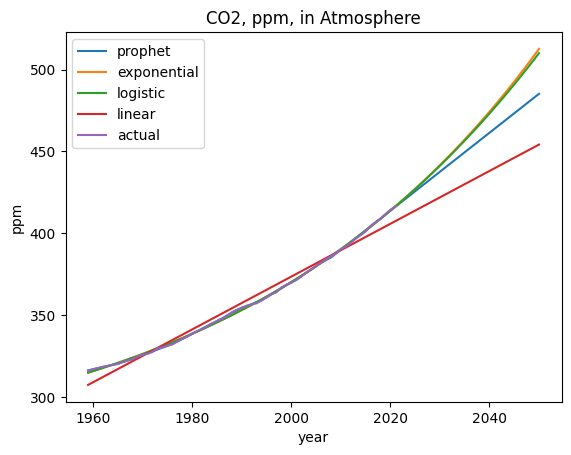

In [104]:
plt.plot(PRED_YEARS, co2_pred_prophet, label='prophet')
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_logi, label='logistic')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO2, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()


## Temperature Predictions

### Linear

In [38]:
m_lr = LinearRegression()
m_lr.fit(temp_df[['year']], temp_df[['y']])

temp_pred_lr = m_lr.predict(PRED_YEARS)
temp_pred_lr = pd.DataFrame(temp_pred_lr)
temp_pred_lr.columns = ['y']

In [52]:
bivariate_stats(temp_df['y'], temp_pred_lr['y'])
error_stats(temp_df['y'], temp_pred_lr[:63])
linear_reg_func(m_lr)


PMCC: 0.9477123036837336 
r^2:  0.8981586105535293 
Cov:  0.09503998934641489
MSE:  0.01060544258324593 
RMSE: 0.10298272953872377 
R^2:  0.8981586105535309 
MAE:  0.0860926616763789 
MAPE: 0.9274768838224801%
Linear Regressed: y = 0.016818356374807986x - 33.117418074756785


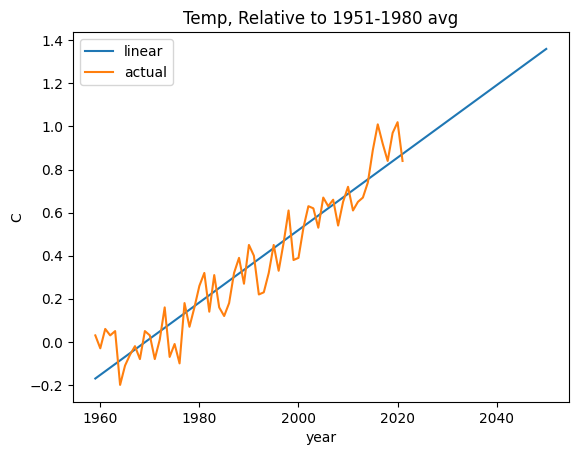

In [40]:
plt.plot(PRED_YEARS, temp_pred_lr, label='linear')
plt.plot(temp_df['year'], temp_df['y'], label='actual')
plt.title('Temp, Relative to 1951-1980 avg')
plt.ylabel('C')
plt.xlabel('year')
plt.legend()
plt.show()


### Prophet

In [41]:
M3 = temp_df.copy()
M3.columns = ['ds', 'y']
M3['ds'] = pd.to_datetime(M3.ds, format='%Y')

In [42]:
P = Prophet(yearly_seasonality=False)
P.fit(M3)


23:23:31 - cmdstanpy - INFO - Chain [1] start processing
23:23:31 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
temp_forecast_df = P.predict(PRED_YEARS_PROPHET.copy())
temp_forecast_df


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,-0.169525,-0.300533,-0.039432,-0.169525,-0.169525,0.0,0.0,0.0,0.0,0.0,0.0,-0.169525
1,1960-01-01,-0.152765,-0.274649,-0.026215,-0.152765,-0.152765,0.0,0.0,0.0,0.0,0.0,0.0,-0.152765
2,1961-01-01,-0.135959,-0.262071,-0.009163,-0.135959,-0.135959,0.0,0.0,0.0,0.0,0.0,0.0,-0.135959
3,1962-01-01,-0.119199,-0.243159,-0.004207,-0.119199,-0.119199,0.0,0.0,0.0,0.0,0.0,0.0,-0.119199
4,1963-01-01,-0.102439,-0.227032,0.025118,-0.102439,-0.102439,0.0,0.0,0.0,0.0,0.0,0.0,-0.102439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2046-01-01,1.294085,1.163570,1.422462,1.293849,1.294337,0.0,0.0,0.0,0.0,0.0,0.0,1.294085
88,2047-01-01,1.310921,1.171892,1.454533,1.310671,1.311183,0.0,0.0,0.0,0.0,0.0,0.0,1.310921
89,2048-01-01,1.327756,1.189979,1.467593,1.327492,1.328033,0.0,0.0,0.0,0.0,0.0,0.0,1.327756
90,2049-01-01,1.344638,1.220002,1.475747,1.344355,1.344930,0.0,0.0,0.0,0.0,0.0,0.0,1.344638


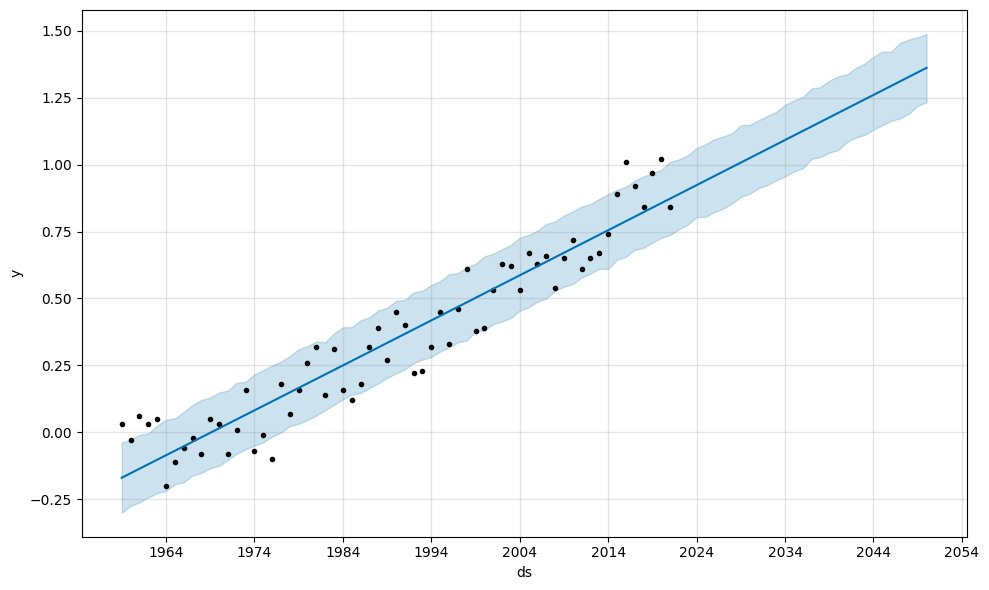

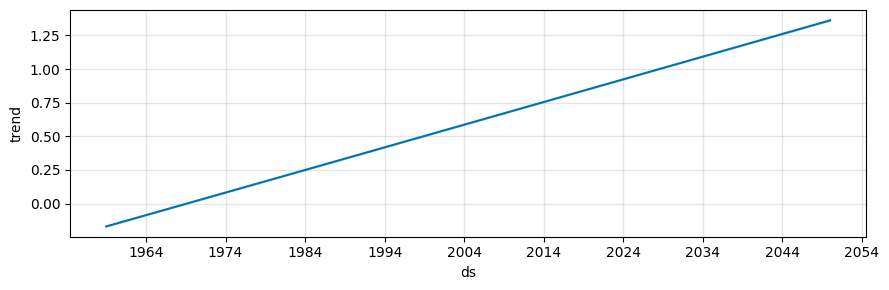

In [44]:
fig3 = P.plot(temp_forecast_df)
fig4 = P.plot_components(temp_forecast_df)

In [45]:
temp_pred_prophet = temp_forecast_df[['yhat']]
temp_pred_prophet.columns = ['y']

In [51]:
bivariate_stats(temp_df['y'], temp_pred_prophet['y'])
error_stats(temp_df['y'], temp_pred_prophet['y'][:63])

PMCC: 0.9478492165935094 
r^2:  0.8984181373969296 
Cov:  0.09503428630069044
MSE:  0.010578428895093143 
RMSE: 0.10285148951324498 
R^2:  0.8984180161854938 
MAE:  0.08602790053904663 
MAPE: 0.9258327331604272%


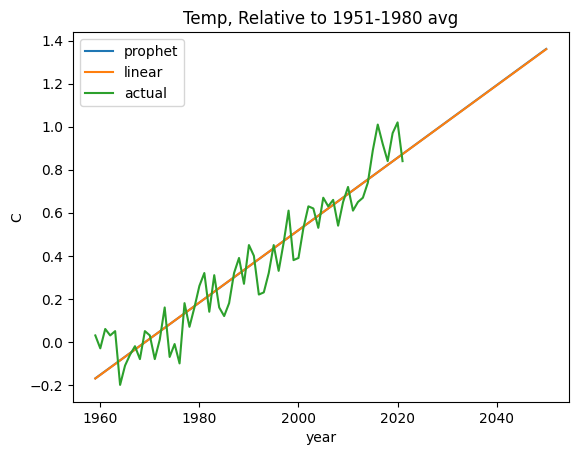

Linear and Prophet are in complete overlap


In [47]:
plt.plot(PRED_YEARS, temp_pred_prophet, label='prophet')
plt.plot(PRED_YEARS, temp_pred_lr, label='linear')
plt.plot(temp_df['year'], temp_df['y'], label='actual')
plt.title('Temp, Relative to 1951-1980 avg')
plt.ylabel('C')
plt.xlabel('year')
plt.legend()
plt.show()

print('Linear and Prophet are in complete overlap')
